# Vehicle Detection and Tracking

---

In [184]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import os
import time

%matplotlib inline

## Load Data

In [2]:
test_images = [mpimg.imread('test_images/' + file) for file in os.listdir('test_images')]

In [3]:
# These are all 64x64 png images

vehicles_folders = ['data/vehicles/GTI_Far/', 'data/vehicles/GTI_Left/', 'data/vehicles/GTI_MiddleClose/', 'data/vehicles/GTI_Right/', 'data/vehicles/KITTI_extracted/']
nonvehicles_folders = ['data/non-vehicles/Extras/', 'data/non-vehicles/GTI/']

udacity_vehicles = [mpimg.imread(folder + file) for folder in vehicles_folders for file in os.listdir(folder)]
udacity_non_vehicles = [mpimg.imread(folder + file) for folder in nonvehicles_folders for file in os.listdir(folder)]

udacity_features_raw = np.concatenate((udacity_vehicles, udacity_non_vehicles))

## Augment Data

In [162]:
def scale_transform(image):
    scale = 1.0 + np.random.random() * 0.4
    translate_x = np.random.randint(-10,10)
    translate_y = np.random.randint(-10,10)
    translation_matrix = 

## Train SVM

In [223]:
def feature_pipeline(image, feature_vector=True):
    cells_per_block = (2,2)
    pixels_per_cell = (16,16)
    orientations= 7
    
    image = cv2.resize(image, (64, 64))
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    ch0 = yuv[:,:,0]
    ch1 = yuv[:,:,1]
    ch2 = yuv[:,:,2]
    ch0_features = hog(ch0, orientations, pixels_per_cell, cells_per_block, feature_vector=feature_vector)
    ch1_features = hog(ch1, orientations, pixels_per_cell, cells_per_block, feature_vector=feature_vector)
    ch2_features = hog(ch2, orientations, pixels_per_cell, cells_per_block, feature_vector=feature_vector)
    hog_features = np.concatenate((ch0_features, ch1_features, ch2_features))
#     print(hog_features.shape)
    return hog_features

In [224]:
start = time.time()

udacity_features = [feature_pipeline(image) for image in udacity_features_raw]
udacity_labels = np.concatenate((np.ones(len(udacity_vehicles)), np.zeros(len(udacity_non_vehicles))))

scaler = StandardScaler()
scaler.fit(udacity_features)
udacity_features_scaled = scaler.transform(udacity_features)

end = time.time()

print('Runtime (s):', end - start)

Runtime (s): 142.36266493797302


In [228]:
start = time.time()

split_index = int(len(udacity_features_scaled) * .8)
X_train = udacity_features_scaled[0: split_index]
X_test = udacity_features_scaled[split_index:]
y_train = udacity_labels[0:split_index]
y_test = udacity_labels[split_index:]
# X_train, X_test, y_train, y_test = train_test_split(udacity_features_scaled, udacity_labels)

svc = LinearSVC(C=1e-6)
svc.fit(X_train, y_train)

train_accuracy = svc.score(X_train, y_train)
val_accuracy = svc.score(X_test, y_test)

end = time.time()

print('Train Accuracy: ', train_accuracy)
print('Val Accuracy: ', val_accuracy)
print('Model runtime (s):', end - start)

Train Accuracy:  0.944890202703
Val Accuracy:  0.940596846847
Model runtime (s): 1.2773997783660889


## Pipeline

In [229]:
def pipeline(image):
    image = np.copy(image)
    search_spaces = [(360, 720, 150, 50), (400, 600, 100, 35), (400, 550, 75, 25)]
    colors = [(255,0,0), (0,255,0), (0,0,255)]
    heatmap = np.zeros_like(image)
    
    for color, space in zip(colors, search_spaces):
        windows = sliding_windows(*space)
        window_images = [image[y1:y2,x1:x2][np.newaxis, ...] for x1,y1,x2,y2 in windows]
        window_images = np.concatenate(window_images, axis=0)
        features = [feature_pipeline(window_image)[np.newaxis,...] for window_image in window_images]
        features = np.concatenate(features)
    
        features_scaled = scaler.transform(features)
        pred = svc.predict(features_scaled)   
        
        for window, guess in zip(windows, pred):
            if guess == 1:
                cv2.rectangle(image, (window[0], window[1]), (window[2], window[3]), color, 5)
#                 heatmap[window[1]:window[3], window[0]:window[2]] += 50  
    return image

def sliding_windows(ystart, ystop, size, step, shape=(720, 1280)):
    return [(x,y, x+size, y+size) for y in range(ystart, ystop - size, step) for x in range(0, shape[1] - size, step)]

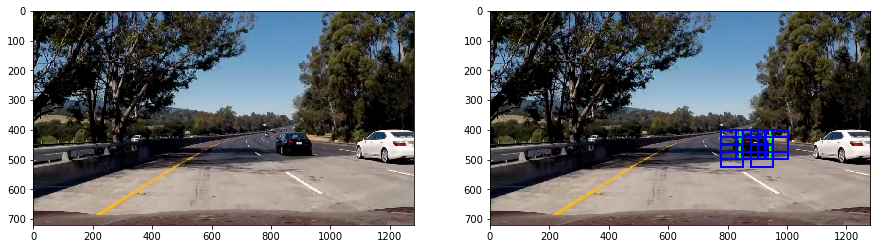

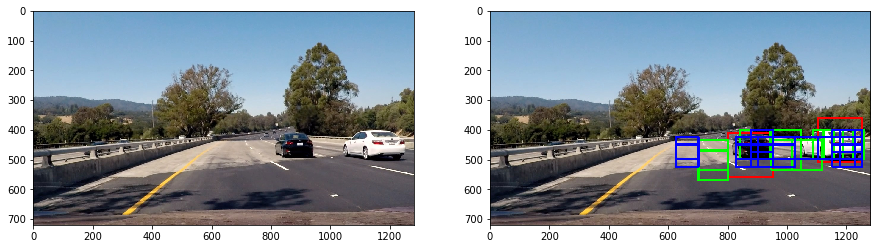

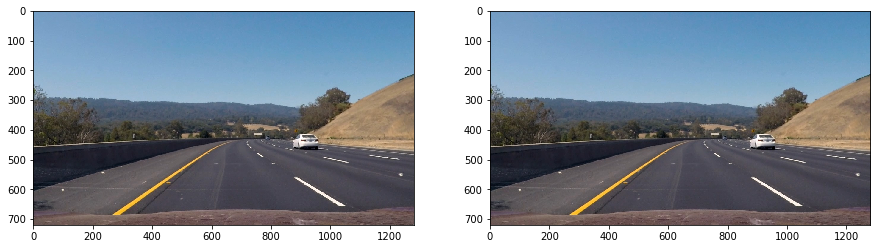

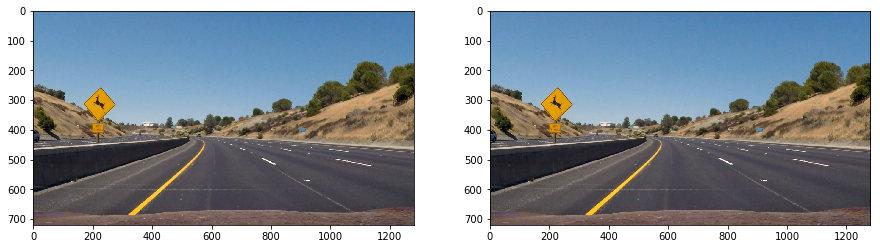

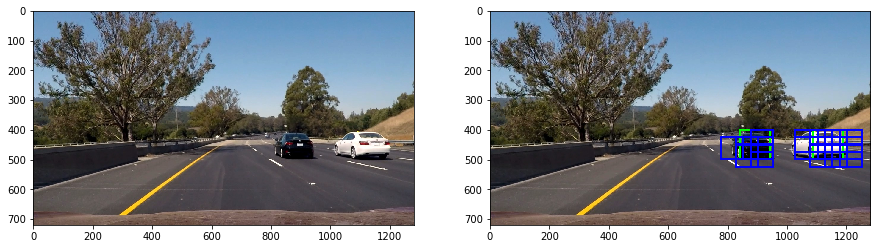

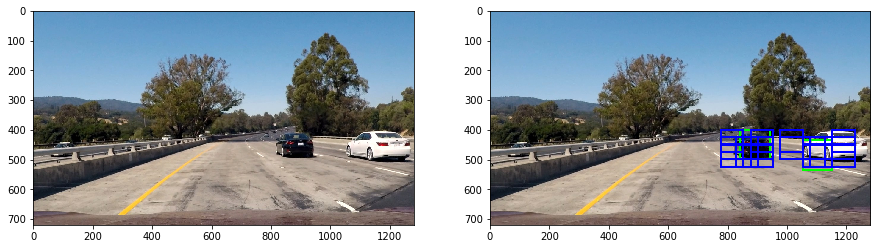

In [230]:
for image in test_images:
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    processed = pipeline(image)
    plt.imshow(processed)

## Video

In [183]:
clip = VideoFileClip('test_video.mp4')
processed_vid = clip.fl_image(pipeline).subclip(0,2)
%time processed_vid.write_videofile('processed_video.mp4', audio=False)

[MoviePy] >>>> Building video processed_video.mp4
[MoviePy] Writing video processed_video.mp4



 98%|█████████▊| 50/51 [03:05<00:03,  3.77s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_video.mp4 

CPU times: user 3min 13s, sys: 1min 14s, total: 4min 28s
Wall time: 3min 7s


In [185]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format('processed_video.mp4'))